In [7]:
from collections import defaultdict

from torch.utils.data import DataLoader
import scan_dataset
import models
import pipeline
import torch
import wandb
import os
from matplotlib import pyplot as plt
import numpy as np
import pickle
from tqdm import tqdm
import seaborn as sns

In [2]:
input_lang = scan_dataset.Lang()
output_lang = scan_dataset.Lang()

test_dataset = scan_dataset.ScanDataset(
    split=scan_dataset.ScanSplit.ADD_PRIM_SPLIT,
    input_lang=input_lang,
    output_lang=output_lang,
    train=False,
    split_variation='turn_left'
)

In [3]:
encoder = pickle.load(open(f'runs/experiment_best_encoder_exp_3_run_1.sav', 'rb'))
decoder = pickle.load(open(f'runs/experiment_best_decoder_exp_3_run_1.sav', 'rb'))

In [11]:
encoder.eval()
decoder.eval()

n_correct = [] # number of correct predictions

with torch.no_grad():

    # take a random example from dataset
    input, target = test_dataset[10]

    input_tensor, target_tensor = test_dataset.convert_to_tensor(input, target)

    target_length = target_tensor.size(0)
    pred = []

    encoder_outputs, encoder_hidden = encoder(input_tensor)

    decoder_input = torch.tensor([[scan_dataset.SOS_token]])

    decoder_hidden = encoder_hidden
    
    target_length = target_tensor.size(0)

    attention = []

    for di in range(target_length):
        decoder_output, decoder_hidden = decoder(
            decoder_input, decoder_hidden, encoder.all_hidden_states)

        topv, topi = decoder_output.topk(1)
        decoder_input = topi.detach()  # detach from history as input

        pred.append(decoder_input.item())

        attention.append(decoder.decoder_cell.attention.attention_weights.detach().cpu().numpy())

        if decoder_input.item() == scan_dataset.EOS_token:
            break

In [13]:
input, target

('walk around right twice after turn left thrice',
 'I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK')

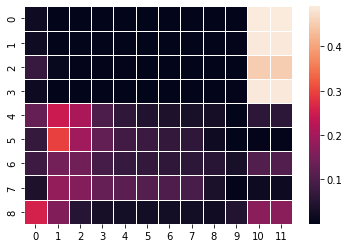

In [8]:
ax = sns.heatmap(attention, linewidth=0.5)
plt.show()